## Project description

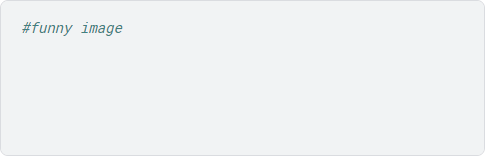

The clients began to leave the bank every month. It is necessary to predict whether the client leaves the bank in the near future or not. You need to build a model with the largest F1-score.

## Data description

In [1]:
import pandas as pd
import numpy as np
# camel case to snake case
import re
# converting from categorical to numeric
from sklearn.preprocessing import OrdinalEncoder
# to scale
from sklearn.preprocessing import  StandardScaler
# to split and shuffle
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
# binary models
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
#!pip install TPOT
#!pip install catboost
from tpot import TPOTClassifier
from catboost import CatBoostClassifier
from catboost import Pool
from catboost import cv
import shap
# metrics
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
# plot
from plotly.subplots import make_subplots
import plotly.graph_objs as go

In [2]:
#for kaggle.com
df = pd.read_csv('../input/bank-customer-churn-modeling/Churn_Modelling.csv', index_col=0).reset_index(drop=True)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CustomerId       10000 non-null  int64  
 1   Surname          10000 non-null  object 
 2   CreditScore      10000 non-null  int64  
 3   Geography        10000 non-null  object 
 4   Gender           10000 non-null  object 
 5   Age              10000 non-null  int64  
 6   Tenure           10000 non-null  int64  
 7   Balance          10000 non-null  float64
 8   NumOfProducts    10000 non-null  int64  
 9   HasCrCard        10000 non-null  int64  
 10  IsActiveMember   10000 non-null  int64  
 11  EstimatedSalary  10000 non-null  float64
 12  Exited           10000 non-null  int64  
dtypes: float64(2), int64(8), object(3)
memory usage: 1015.8+ KB


In [4]:
df.head(5)

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


Columns description
- `RowNumber` — row index. When df was created that column was turned into index
- `CustomerId` — client's identifier
- `Surname` — client's last name
- `CreditScore` — credit score
- `Geography` — country of residence
- `Gender` — gender
- `Age` — age
- `Tenure` — how much time the customer is the bank's client
- `Balance` — account balance
- `NumOfProducts` — how many products client uses
- `HasCrCard` — having a credit card
- `IsActiveMember` — client activity
- `EstimatedSalary` — estimated client salary

Target feature
- `Exited` — the fact that the client left the bank


The columns style is camel case, it will be turned into snake case. Values in `HasCrCard` is boolean, so column name will be turned to `is_has_cr_card`. The same with `Exited`.

In [5]:
columns = df.columns
columns_new = []
for name in columns:
  columns_new.append(re.sub(r'(?<!^)(?=[A-Z])', '_', name).lower())
columns_new

['customer_id',
 'surname',
 'credit_score',
 'geography',
 'gender',
 'age',
 'tenure',
 'balance',
 'num_of_products',
 'has_cr_card',
 'is_active_member',
 'estimated_salary',
 'exited']

In [6]:
df.set_axis(columns_new, axis='columns', inplace=True)
df = df.rename(columns={'has_cr_card' : 'is_has_cr_card', 'exited' : 'is_exited'})
df.columns

Index(['customer_id', 'surname', 'credit_score', 'geography', 'gender', 'age',
       'tenure', 'balance', 'num_of_products', 'is_has_cr_card',
       'is_active_member', 'estimated_salary', 'is_exited'],
      dtype='object')

Checking for duplicates

In [7]:
df['customer_id'].duplicated().sum()

0

## Conclusion

Data is loaded, mistakes and NaN weren't found, duplicates weren't found. Header style was changed to snake case.

## Data prepearing

Outliers analysis


For usability there will be made some functions and added to custom class

In [8]:
def df_plots(df, list_cols_names,
                      title_text='Boxblot', kind='Box',
                      rows=1, cols=1, height=500, width=800,
                      y_for_Bar=''):
  '''Function receives DataFrame data and list columns names,
  when builds Boxblot or Histogram or Bar
  - imports:
  import plotly.graph_objs as go
  from plotly.subplots import make_subplots'''

  fig = make_subplots(rows=rows, cols=cols)
  row = 1
  col = 1
  for col_name in list_cols_names:
    if kind == 'Box':
      fig.append_trace(go.Box(y=df[col_name], name=col_name), row, col)
    elif kind == 'Histogram':
      fig.append_trace(go.Histogram(y=df[col_name], name=col_name), row, col)
    elif kind == 'Bar':
      fig.append_trace(go.Bar(x=df[col_name],y=df[y_for_Bar],name=col_name), row, col)
    col += 1
    if col > cols:
      col = 1
      row +=1
  
  fig.update_layout(title_text=title_text, height=height, width=width)
  fig.show()

class myfunc:
  '''Custom functions'''
myfunc.df_plots =  df_plots

In [9]:
list_cols_names = ['credit_score', 'balance', 'tenure', 'num_of_products',	'is_has_cr_card',	'is_active_member', 'estimated_salary', ]
myfunc.df_plots(df, list_cols_names, rows=2, cols=4, kind='Box', height=600, width=1200)

In [10]:
myfunc.df_plots(df, list_cols_names, rows=2, title_text='Histogram', cols=4, kind='Histogram', height=600, width=1200)

In `credit_score` and `is_exited` there are some outliers, checking them

In [11]:
df[df['credit_score'] < 383]['is_exited'].value_counts()

1    15
Name: is_exited, dtype: int64

In [12]:
df[df['num_of_products'] == 4]['is_exited'].value_counts()

1    60
Name: is_exited, dtype: int64

There are only '1' values in `is_exited` that mean that there are no outliers

Outliers were not found

Columns data should be converted from categorical to numeric values: `geography`, `gender`


In [13]:
df['geography'].unique()

array(['France', 'Spain', 'Germany'], dtype=object)

In [14]:
df['gender'].unique()

array(['Female', 'Male'], dtype=object)

Columns don't have many values, so it will be used the OHE coding

In [15]:
df_copy =  df.copy()

In [16]:
one_hot = pd.get_dummies(df[['geography', 'gender']], drop_first=True)

df = df.join(one_hot).drop(['geography', 'gender'], axis=1)

Columns data need to be scaled: `credit_score`, `balance` `estimated_salary`

In [17]:
temp_df = df[['credit_score', 'balance', 'estimated_salary']]
scaler = StandardScaler()
df[['credit_score', 'balance', 'estimated_salary']] = pd.DataFrame(scaler.fit_transform(temp_df), columns=temp_df.columns) 

Checking target column balance

In [18]:
print('Percentage of positive values: {:.2%}'.format(df['is_exited'].mean()))

Percentage of positive values: 20.37%


## Conclusion


Outliers were not found. Values in columns `geography`, `gender` were converted to numeric. Data in columns `credit_score`, `balance`, `estimated_salary` were scaled. Target class is imbalanced, so it will be upsampled and downsamples later

## Custom functions

To build models and to analyze their predictions there will be added some functions

Split function is to divide data for train, valid and test parts.

In [19]:
def split_df(df, list_dpop_cols_names, target_col_name, cv=False):
  '''Function receives DataFrame, split it to train (60%), valid (20%), test (20%) data,
  also receives list of names columns to drop and target column name.
  Returns data as dict,
  Function also print the splitted data shape
  If cv=True function returns dict with train 75% and test 25% data
  - imports:
  from sklearn.model_selection import train_test_split'''
  list_dpop_cols_names.append(target_col_name)
  X = df.drop(list_dpop_cols_names, axis=1)
  y = df[target_col_name]
  X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.20, random_state=123456)
  X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.25, random_state=123456)
  
  if cv:
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, random_state=123456)
    print('X_train:',X_train.shape,'X_test:', X_test.shape)
    return {'X_train': X_train, 'y_train': y_train, 'X_test': X_test, 'y_test': y_test}
  else:
    print('X_train:',X_train.shape,'X_valid:',X_valid.shape,'X_test:', X_test.shape)
    return {'X_train': X_train, 'y_train': y_train, 'X_valid': X_valid, 'y_valid': y_valid, 'X_test': X_test, 'y_test': y_test}

myfunc.split_df = split_df

Plot function builds line plots with ROC-curve

In [20]:
def plot_roc(y_valid, list_data):
  '''Function receives y_valid data and list which contains
  lists [name (text model name),
  probabilities (model.predict_proba),
  prediction (model.predict),
  caption (text caption in df)] 
  when builds plots presenting ROC-curve'''
  fig = make_subplots(rows=1, cols=1)#, shared_yaxes=True) 
  for list_value in list_data:
      probabilities = list_value[1]
      prediction = list_value[2]
      probabilities_one = probabilities[:, 1]
      f1 = f1_score(y_valid, prediction)
      auc_roc = roc_auc_score(y_valid, probabilities_one)
      fpr, tpr, thresholds = roc_curve(y_valid, probabilities_one)
      fig.add_trace(go.Scatter(x=fpr,
                                y=tpr,
                                mode='lines',
                                name=str('ROC-AUC score {:.2} '.format(roc_auc_score(y_valid, probabilities[:, 1])) + list_value[0])
                                )
                    )
  fig.update_layout(title_text=str("ROC-curve " + list_value[3]),
                    xaxis_title="False Positive Rate",
                    yaxis_title="True Positive Rate",
                    height=500,
                    width=800)
  fig.show()

myfunc.plot_roc = plot_roc

Сlassification function makes DataFrame with metrics

In [21]:
def classification_df(y_valid, list_data):
  '''Function receives y_valid data and list which contains
  lists [name (text model name),
  probabilities (model.predict_proba),
  prediction (model.predict),
  caption (text caption in df)] 
  then returns a classification report
  - imports
  from sklearn.metrics import classification_report'''
  sanity_result = pd.DataFrame()
  for list_value in list_data:
      prediction = list_value[2]
      sanity_df = pd.DataFrame(classification_report(
            y_valid,
            prediction,
            output_dict=True
            ))
      sanity_df['model_type'] = list_value[0]
      sanity_df['caption'] = list_value[3]
      if sanity_result.size == 0:
        sanity_result = sanity_df
      else:
        sanity_result = sanity_result.append(sanity_df)
  return sanity_result

myfunc.classification_df = classification_df

Compare function builds a few kinds of models. It uses the classification function, so as the result it returns DataFrame with metrics

In [22]:
def compare_categorical_models (splitted_df, caption, is_show_plot=False):
  '''Function receives dict of splitted data (which is returned function split_df()).
  It builds a few kinds of models.
  Function returns a classification report of models (call function classification_df())
  If is_show_plot=True then in will build a plot (call function myfunc.plot_roc()) for each kind of models.'''
  list_data = []
# logistic
  model_logistic = LogisticRegression(random_state=123456,
                                      solver='liblinear'
                                      ).fit(splitted_df['X_train'], splitted_df['y_train'])
  list_data.append(['logistic',
                model_logistic.predict_proba(splitted_df['X_valid']),
                model_logistic.predict(splitted_df['X_valid']),
                caption])
# forest
  model_forest = RandomForestClassifier(random_state=123456,
                                        n_estimators=300
                                        ).fit(splitted_df['X_train'], splitted_df['y_train'])
  list_data.append(['forest',
                    model_forest.predict_proba(splitted_df['X_valid']),
                    model_forest.predict(splitted_df['X_valid']),
                    caption]) 
# pipeline_optimizer
  pipeline_optimizer = TPOTClassifier(generations=2,
                                      population_size=10,
                                      random_state=123456,
                                      verbosity=0,
                                      n_jobs=-1,
                                      scoring='f1').fit(splitted_df['X_train'], splitted_df['y_train'])
  list_data.append(['pipeline_optimizer',
                    pipeline_optimizer.predict_proba(splitted_df['X_valid']),
                    pipeline_optimizer.predict(splitted_df['X_valid']),
                    caption])
# CatBoostClassifier
  model_cat_boost = CatBoostClassifier(random_state=123456,
                                        custom_loss=['F1'],
                                        iterations=100,
                                        logging_level='Silent').fit(splitted_df['X_train'], splitted_df['y_train'])
  list_data.append(['cat boost',
                    model_cat_boost.predict_proba(splitted_df['X_valid']),
                    model_cat_boost.predict(splitted_df['X_valid']),
                    caption])

  if is_show_plot:
    myfunc.plot_roc(splitted_df['y_valid'], list_data) #plot
  return myfunc.classification_df(splitted_df['y_valid'], list_data) #classification

myfunc.compare_categorical_models = compare_categorical_models

To balance classes will be created 2 functions:
- `upsample()` to upsample the data
- `downsample()` to downsample

In [23]:
def upsample(splitted_df):
  '''Function receives dict of splitted data (which is returned function split_df()).
  Increase the amount of zeros or ones (which is less in y) and return upsampled data'''
  splitted_df_upsampled = splitted_df.copy()
  X = splitted_df_upsampled['X_train']
  y = splitted_df_upsampled['y_train']
  X_zeros = X[y == 0]
  X_ones = X[y == 1]
  y_zeros = y[y == 0]
  y_ones = y[y == 1]
  print('zeros size:', X_zeros.index.size, 'ones size:', X_ones.index.size)
  diff = int(X_zeros.index.size / X_ones.index.size)
  if diff > 0:
    X_upsampled = pd.concat([X_zeros] + [X_ones] * diff)
    y_upsampled = pd.concat([y_zeros] + [y_ones] * diff)
  else:
    diff = int(X_ones.index.size / X_zeros.index.size)
    if diff > 0:
      X_upsampled = pd.concat([X_zeros] * diff + [X_ones])
      y_upsampled = pd.concat([y_zeros] * diff + [y_ones])
  X_upsampled, y_upsampled = shuffle(X_upsampled, y_upsampled, random_state=123456)
  X_zeros_upsampled = X_upsampled[y_upsampled == 0]
  X_ones_upsampled = X_upsampled[y_upsampled == 1]
  print('zeros size upsampled:', X_zeros_upsampled.index.size, 'ones size upsampled:', X_ones_upsampled.index.size)
  splitted_df_upsampled['X_train'] = X_upsampled
  splitted_df_upsampled['y_train'] = y_upsampled
  return splitted_df_upsampled

myfunc.upsample = upsample

In [24]:
def downsample(splitted_df):
  '''Function receives list of splitted data (with is returned function split_df()).
  Decrease the amount of zeros or ones (which is more in y) and return downsampled data'''
  splitted_df_downsampled = splitted_df.copy()
  X = splitted_df_downsampled['X_train']
  y = splitted_df_downsampled['y_train']
  X_zeros = X[y == 0]
  X_ones = X[y == 1]
  y_zeros = y[y == 0]
  y_ones = y[y == 1]
  print('zeros size', X_zeros.index.size, 'ones size', X_ones.index.size)
  diff = X_zeros.index.size / X_ones.index.size * 1.2 
  if diff < 1:
    X_downsampled = pd.concat([X_ones.sample(frac=diff, random_state=123456)] + [X_zeros])
    y_downsampled = pd.concat([y_ones.sample(frac=diff, random_state=123456)] + [y_zeros])
  else:
    diff = X_ones.index.size / X_zeros.index.size * 1.2
    if diff < 1:
      X_downsampled = pd.concat([X_zeros.sample(frac=diff, random_state=123456)] + [X_ones])      
      y_downsampled = pd.concat([y_zeros.sample(frac=diff, random_state=123456)] + [y_ones])
  
  X_downsampled, y_downsampled = shuffle(X_downsampled, y_downsampled, random_state=123456)
  X_zeros_downsampled = X_downsampled[y_downsampled == 0]
  X_ones_downsampled = X_downsampled[y_downsampled == 1]
  print('zeros size downsampled', X_zeros_downsampled.index.size, 'ones size downsampled', X_ones_downsampled.index.size)
  splitted_df_downsampled['X_train'] = X_downsampled
  splitted_df_downsampled['y_train'] = y_downsampled
  return splitted_df_downsampled

myfunc.downsample = downsample

## Conclusion

The created functions are:
- `split_df()` - to split data
- `plot_roc()` - to build plots presenting ROC-curve
- `classification_df()` - to make classification report
- `compare_categorical_models()` - to build a few kinds of models
- `upsample()` to upsample the data
- `downsample()` to downsample

## Data analysis, models research

Splitting.  The columns specified to user's data `customer_id` and `surname` will be dropped

In [25]:
splitted_df = myfunc.split_df(df, ['customer_id', 'surname'], 'is_exited')

X_train: (6000, 11) X_valid: (2000, 11) X_test: (2000, 11)


In [26]:
splitted_df['X_train'].sample(3)

,credit_score,age,tenure,balance,num_of_products,is_has_cr_card,is_active_member,estimated_salary,geography_Germany,geography_Spain,gender_Male
3968,-0.015818,40,4,0.296749,1,0,1,0.401908,1,0,1
5730,-1.153963,29,4,-1.225848,2,1,1,0.014415,0,0,0
5874,-0.553850,19,2,-1.225848,2,1,1,-0.157431,0,0,1


Models building

In [27]:
classification_report_result = pd.DataFrame()

classification_report_result = myfunc.compare_categorical_models(splitted_df,
                                                          'Imbalanced df',
                                                          is_show_plot=True)

Among all the plots, the best ROC-curve for cat boost model. At the end of research we'll see the best F1-score, if it is also the cat boost model, it will be the best from considering models.

Build models for DataFrame with upsampled data. Metric's report will be saved in a variable `classification_report_result`

In [28]:
classification_report_result = classification_report_result.append(
    myfunc.compare_categorical_models(myfunc.upsample(splitted_df),'Upsampled df', is_show_plot=True))

zeros size: 4773 ones size: 1227
zeros size upsampled: 4773 ones size upsampled: 3681


Building models for downsampled data. Metric's report will be saved in a variable `classification_report_result`

In [29]:
classification_report_result = classification_report_result.append(
    myfunc.compare_categorical_models(myfunc.downsample(splitted_df),'Downsampled df', is_show_plot=True))

zeros size 4773 ones size 1227
zeros size downsampled 1472 ones size downsampled 1227


The 10 best F1-score models

In [30]:
classification_report_result = classification_report_result[classification_report_result.index == 'f1-score'][{'1', 'macro avg', 'model_type', 'caption'}]
classification_report_result.sort_values(by='1', ascending=False).head(10)

,macro avg,model_type,caption,1
f1-score,0.756434,cat boost,Upsampled df,0.619429
f1-score,0.752165,cat boost,Downsampled df,0.619202
f1-score,0.740457,forest,Downsampled df,0.602769
f1-score,0.734349,pipeline_optimizer,Downsampled df,0.599797
f1-score,0.743116,forest,Upsampled df,0.578581
f1-score,0.732678,cat boost,Imbalanced df,0.553707
f1-score,0.722842,pipeline_optimizer,Imbalanced df,0.534375
f1-score,0.720718,forest,Imbalanced df,0.529968
f1-score,0.709868,pipeline_optimizer,Upsampled df,0.509677
f1-score,0.660476,logistic,Downsampled df,0.492582


The best F1-score macro avg is 0.756 from the model CatBoostClassifier which was trained on upsampled data.


## Conclusion

The best F1-score macro avg is 0.756 on the model CatBoostClassifier which was trained on upsampled data. Also CatBoostClassifier shows the best ROC-curves.

## Model tuning

Model CatBoostClassifier is the best, so let's tune it

CatBoostClassifier make following processes by it own:
- balancing classes
- One-hot encoding
- cross validation

Also, no need to scale features

In [31]:
df_copy.sample(3)

,customer_id,surname,credit_score,geography,gender,age,tenure,balance,num_of_products,is_has_cr_card,is_active_member,estimated_salary,is_exited
5733,15742798,French,829,France,Female,22,7,150126.44,1,1,0,152107.93,1
6988,15769451,Hayes,764,France,Female,44,1,0.00,2,1,1,11467.38,0
4426,15749557,Chao,707,France,Female,44,6,0.00,2,1,1,192542.17,0


Add classifications columns to variable

In [32]:
cat_features = ['geography', 'gender']

Column `surname` specified to user's data and will be dropped. Also, there is a column `customer_id`, in the previous part of code it was dropped, but let's check it, maybe there is a connection to target. ID usually the historical data, and it shows which user was registered later than another one

In [33]:
list_data_up = myfunc.split_df(df_copy, ['surname'], 'is_exited', cv=True)

X = list_data_up['X_train']
y = list_data_up['y_train']
X_test = list_data_up['X_test']
y_test = list_data_up['y_test']

X_train: (7500, 11) X_test: (2500, 11)


In [34]:
params = {'loss_function':'Logloss',
          'eval_metric':'F1',
          'cat_features': cat_features,
          'auto_class_weights': 'Balanced',
          'random_seed': 123456,
          'early_stopping_rounds': 200,
          'verbose': 200,
         }

model_cv = CatBoostClassifier(**params)

In [35]:
pool = Pool(X, y, cat_features = cat_features)

Cross validation 

In [36]:
cv_data = cv(pool, model_cv.get_params())

Training on fold [0/3]
0:	learn: 0.7506872	test: 0.7318374	best: 0.7318374 (0)	total: 8.38ms	remaining: 8.37s
200:	learn: 0.8224416	test: 0.7580087	best: 0.7676612 (104)	total: 1.24s	remaining: 4.95s

bestTest = 0.7676612133
bestIteration = 104

Training on fold [1/3]
0:	learn: 0.7445732	test: 0.7293899	best: 0.7293899 (0)	total: 6.66ms	remaining: 6.66s
200:	learn: 0.8167560	test: 0.7801713	best: 0.7807751 (185)	total: 1.25s	remaining: 4.98s
400:	learn: 0.8589037	test: 0.7735446	best: 0.7844823 (267)	total: 2.5s	remaining: 3.74s

bestTest = 0.7844823211
bestIteration = 267

Training on fold [2/3]
0:	learn: 0.7613952	test: 0.7579908	best: 0.7579908 (0)	total: 8.38ms	remaining: 8.37s
200:	learn: 0.8151613	test: 0.7768394	best: 0.7775703 (122)	total: 1.3s	remaining: 5.15s
400:	learn: 0.8548861	test: 0.7804248	best: 0.7867868 (339)	total: 2.74s	remaining: 4.09s

bestTest = 0.7867867686
bestIteration = 339



F1 score is better when it was earlier

<AxesSubplot:>

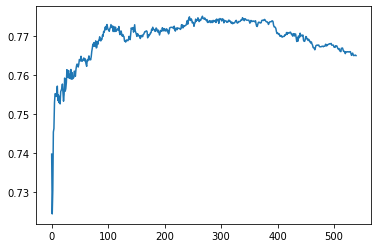

In [37]:
cv_data['test-F1-mean'].plot()

Best F1 was at 200-300 iterations. Let's try to reduce the learning rate in a next try.

In [38]:
params = {'loss_function':'Logloss',
          'learning_rate': 0.01,
          'eval_metric':'F1',
          'cat_features': cat_features,
          'auto_class_weights': 'Balanced',
          'random_seed': 123456,
          'early_stopping_rounds': 200,
          'verbose': 200,
         }

model_cv = CatBoostClassifier(**params)

In [39]:
cv_data = cv(pool, model_cv.get_params())

Training on fold [0/3]
0:	learn: 0.7506872	test: 0.7318374	best: 0.7318374 (0)	total: 9.93ms	remaining: 9.92s
200:	learn: 0.7877108	test: 0.7609983	best: 0.7609983 (193)	total: 1.39s	remaining: 5.54s
400:	learn: 0.8079813	test: 0.7644019	best: 0.7661715 (305)	total: 2.66s	remaining: 3.98s
600:	learn: 0.8207699	test: 0.7645303	best: 0.7684105 (500)	total: 3.98s	remaining: 2.64s
800:	learn: 0.8338781	test: 0.7680756	best: 0.7706625 (765)	total: 5.24s	remaining: 1.3s

bestTest = 0.770662511
bestIteration = 765

Training on fold [1/3]
0:	learn: 0.7445732	test: 0.7293899	best: 0.7293899 (0)	total: 8.06ms	remaining: 8.05s
200:	learn: 0.7824991	test: 0.7742879	best: 0.7761696 (182)	total: 1.32s	remaining: 5.24s
400:	learn: 0.8045368	test: 0.7766848	best: 0.7810372 (342)	total: 2.58s	remaining: 3.85s

bestTest = 0.7810371568
bestIteration = 342

Training on fold [2/3]
0:	learn: 0.7613952	test: 0.7579908	best: 0.7579908 (0)	total: 8.15ms	remaining: 8.15s
200:	learn: 0.7813233	test: 0.7671198	be

<AxesSubplot:>

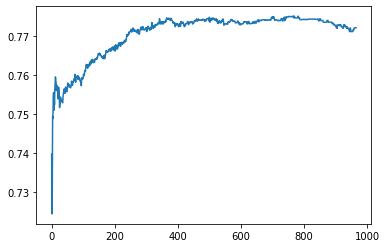

In [40]:
cv_data['test-F1-mean'].plot()

Now it looks better

Let's check for retraining

<AxesSubplot:>

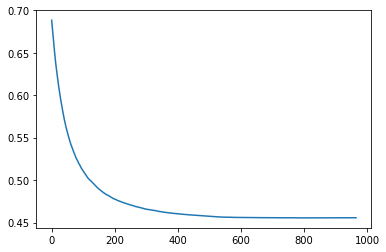

In [41]:
cv_data['test-Logloss-mean'].plot()

The plot shows that there is no retraining

Fitting the model and checking features importance

In [42]:
model_cv.fit(pool)

0:	learn: 0.7318052	total: 7.3ms	remaining: 7.29s
200:	learn: 0.7825247	total: 1.21s	remaining: 4.82s
400:	learn: 0.7976711	total: 2.4s	remaining: 3.59s
600:	learn: 0.8058544	total: 3.57s	remaining: 2.37s
800:	learn: 0.8132792	total: 4.73s	remaining: 1.18s
999:	learn: 0.8258714	total: 6.02s	remaining: 0us


<AxesSubplot:xlabel='feature_names'>

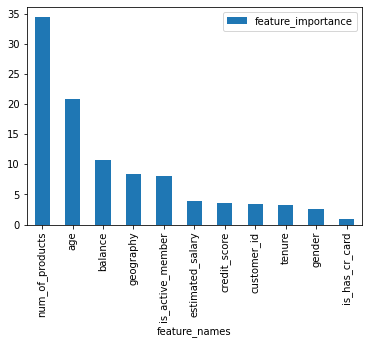

In [43]:
pd.DataFrame({'feature_importance': model_cv.get_feature_importance(data=pool), 
                                                       'feature_names': X.columns}
            ).sort_values(by=['feature_importance'],
                          ascending=False).plot.bar(x='feature_names')

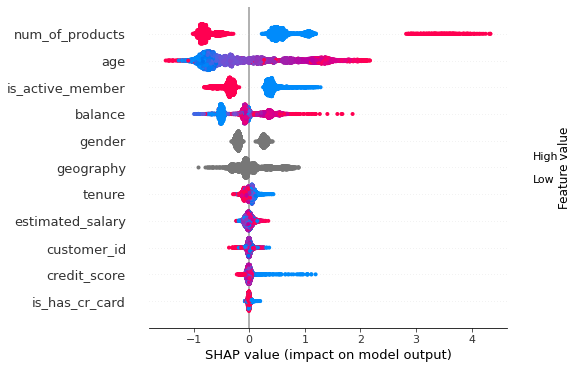

In [44]:
shap_values = model_cv.get_feature_importance(pool,type="ShapValues")
expected_value = shap_values[0,-1]
shap_values = shap_values[:,:-1]
shap.summary_plot(shap_values, X)

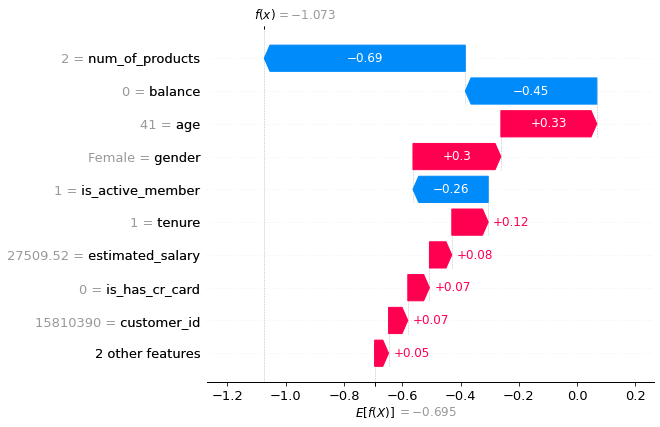

In [45]:
explainer = shap.Explainer(model_cv)
shap_values = explainer(X)
shap.plots.waterfall(shap_values[0])

The assumption about `customer_id` was right, it impacts to target, but not so strong

In [46]:
cv_data['test-F1-mean'].mean()

0.7704509295441972

## Conclusion

The model CatboostClassifier has been improved - from F1-score macro avg 0.756 to 0.77

## Model adequacy check

Build a dummy model

In [47]:
list_data_up = myfunc.split_df(df_copy, ['surname'], 'is_exited')

X = list_data_up['X_train']
y = list_data_up['y_train']
X_valid = list_data_up['X_valid']
y_valid = list_data_up['y_valid']

X_train: (6000, 11) X_valid: (2000, 11) X_test: (2000, 11)


In [48]:
dummy_clf = DummyClassifier(random_state=123456,
                            #strategy='most_frequent'
                            )
dummy_clf.fit(X,y)

/opt/conda/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning:

The default value of strategy will change from stratified to prior in 0.24.



DummyClassifier(random_state=123456)

In [49]:
pd.DataFrame(
    classification_report(
        y_valid,
        dummy_clf.predict(X_valid),
        zero_division=0,
        output_dict=True)
    )

,0,1,accuracy,macro avg,weighted avg
precision,0.796262,0.222785,0.683,0.509523,0.677265
recall,0.806309,0.212048,0.683,0.509179,0.683000
f1-score,0.801254,0.217284,0.683,0.509269,0.680080
support,1585.000000,415.000000,0.683,2000.000000,2000.000000


## Conclusion

F1-score macro avg of the dummy model is much worse than of the CatboostClassifier model - 0.509 and 0.77

## Prediction the test data

Finaly, prediction the test data

In [50]:
roc_auc_score(y_test, model_cv.predict_proba(X_test)[:, 1])

0.8688679254458784

In [51]:
myfunc.plot_roc(y_test, [['Test data', model_cv.predict_proba(X_test), model_cv.predict(X_test), 'model_cv']])

In [52]:
pd.DataFrame(classification_report(
            y_test,
            model_cv.predict(X_test),
            output_dict=True
            ))

,0,1,accuracy,macro avg,weighted avg
precision,0.924528,0.548711,0.8196,0.736619,0.846509
recall,0.840989,0.737958,0.8196,0.789474,0.819600
f1-score,0.880782,0.629417,0.8196,0.755100,0.828599
support,1981.000000,519.000000,0.8196,2500.000000,2500.000000


## Conclusion

F1-score macro avg of the CatboostClassifier model on test data is 0.755

# General conclusion

In loaded data mistakes weren't found, duplicates weren't found, outliers were not found. Values in columns `geography`, `gender` were converted to numeric. Data in columns `balance`, `estimated_salary` were scaled. 3 new DataFrames were created after replacing NaN in `tenure`.

The best model with best F1-score is CatboostClassifier. Also CatboostClassifier model shows the best ROC-curves.

After tuning the model CatboostClassifier has been improved - from F1-score macro avg 0.756 to 0.77

Average F1-score of the dummy model is much worse than of the forest model - 0.509 and 0.77

F1-score macro avg of the CatboostClassifier model on test data is 0.755